In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-11-28 09:05:12.019790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [220]:
# https://finance.yahoo.com/quote/TSLA/history?period1=1290643200&period2=1669334400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = pd.read_csv("./stock/TSLA_2010-2022.csv")
df
# Date : 날짜
# open : 시가
# High : 상한가
# Low : 하한가
# Close : 종가
# Adj Close : 종가
# Volume : 거래량

# 전날 데이터를 가지고 다음날 데이터를 알 수 있다. 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
1,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
3,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
4,2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500
...,...,...,...,...,...,...,...
3119,2022-11-17,183.960007,186.160004,180.899994,183.169998,183.169998,64336000
3120,2022-11-18,185.050003,185.190002,176.550003,180.190002,180.190002,75904900
3121,2022-11-21,175.850006,176.770004,167.539993,167.869995,167.869995,92882700
3122,2022-11-22,168.630005,170.919998,166.190002,169.910004,169.910004,78452300


# 전처리

In [221]:
# 시계열 인덱스를 따로 만들어야 한다.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2022-11-10', '2022-11-11', '2022-11-14', '2022-11-15',
               '2022-11-16', '2022-11-17', '2022-11-18', '2022-11-21',
               '2022-11-22', '2022-11-23'],
              dtype='datetime64[ns]', name='Date', length=3124, freq=None)

In [185]:
# 데이터의량이 많이 때문에 작은 데이터부터 관리

# 날짜가 확인 가능하다.
df['2019-01']

/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/1349837109.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2019-01']


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500
2019-01-09,22.366667,22.900000,22.098000,22.568666,22.568666,81493500
2019-01-10,22.293333,23.025999,22.119333,22.997999,22.997999,90846000
2019-01-11,22.806000,23.227333,22.584667,23.150667,23.150667,75586500
2019-01-14,22.825333,22.833332,22.266666,22.293333,22.293333,78709500


In [222]:
# 2019년 2월의 Adj Close 데이터를 가져온다.
df201901 = df['2019-01']
df201901 = df201901.iloc[:, -2]
df201901

/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/897580893.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df201901 = df['2019-01']


Date
2019-01-02    20.674667
2019-01-03    20.024000
2019-01-04    21.179333
2019-01-07    22.330667
2019-01-08    22.356667
2019-01-09    22.568666
2019-01-10    22.997999
2019-01-11    23.150667
2019-01-14    22.293333
2019-01-15    22.962000
2019-01-16    23.070000
2019-01-17    23.153999
2019-01-18    20.150667
2019-01-22    19.927999
2019-01-23    19.172667
2019-01-24    19.434000
2019-01-25    19.802668
2019-01-28    19.758667
2019-01-29    19.830667
2019-01-30    20.584667
2019-01-31    20.468000
Name: Adj Close, dtype: float64

# 시각화

<AxesSubplot:xlabel='Date'>

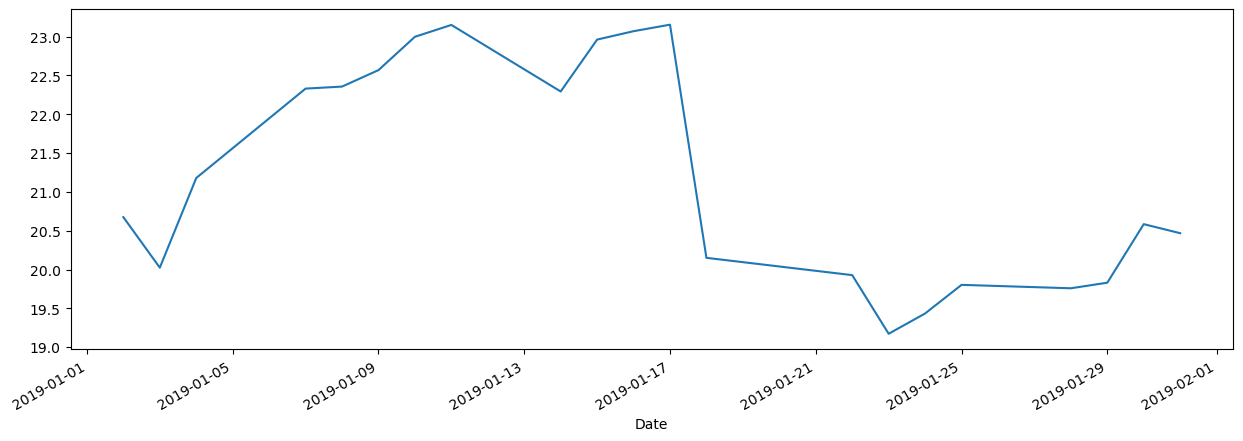

In [187]:
fig, ax = plt.subplots(figsize=(15, 5))
df201901.plot(ax=ax)

# 데이터 분리

In [223]:
df_len = len(df201901)
df_len
# 데이터 프레임을 데이터의 최대 개수로 맞추고 빈자리에 0을 대입한다.

21

In [224]:
from sklearn.model_selection import TimeSeriesSplit

In [344]:
# n_splits : 출력할 전체 개수
# max_train_size : Xtrain 데이터의 최대 개수
# test_size : 결과수, ytest
mts = 20
tss = TimeSeriesSplit(n_splits=df_len-1, max_train_size=mts, test_size=1)

for trn, val in tss.split(df201901):
    print(trn, val)

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]
[0 1 2 3 4 5 6 7 8 9] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [20]


In [146]:
mts = df_len-1
ts = 3
tss = TimeSeriesSplit(n_splits=int(len(df201901)/ts)-1, max_train_size=mts, test_size=ts)
for idx, (trn, val) in enumerate(tss.split(df201901)):
    print(idx, trn, val)

0 [0 1 2] [3 4 5]
1 [0 1 2 3 4 5] [6 7 8]
2 [0 1 2 3 4 5 6 7 8] [ 9 10 11]
3 [ 0  1  2  3  4  5  6  7  8  9 10 11] [12 13 14]
4 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15 16 17]
5 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18 19 20]


In [226]:
# val의 인덱스로 데이터 프레임을 만들고 0으로 채운다. 

ndf = np.zeros([val[0], int(df_len)])
ndf = pd.DataFrame(ndf)
ndf

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 시계열 데이터 프레임 생성
~마지막 전번 컬럼 : train <br>
마지막 컬럼 : val


In [227]:
s = 0
for i in range(val[0]-1, -1, -1):
    for y in range(s, df_len):
        ndf.iloc[i, [y]] = df201902.iloc[y-s]
    s+=1
    
ndf

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333,22.962000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333,22.962000,23.070000


#### 1D Convolutions and recurrent  layers use(batch_size, sequence_length, features)
<br>

1번 모델 : 2개의 히든 레이어, 각 8개씩 노드 구성 최종 1개 결과 예측 <br>
2번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (2 filter, 3 size) <br>
3번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (10 filter, 10 size) <br>

In [340]:
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values

X.shape

(20, 20)

# DL 모델 추가

#### 1번 모델 생성

In [331]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = keras.layers.Dense(8, activation="relu")(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model = keras.Model(inputs, output)
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model.summary()



# model1 = Sequential()
# model1.add(Dense(8, input_shape = X.shape[0], activation='relu'))
# model1.add(Dense(8, activation='relu'))
# model1.add(Dense(1))

# model1.compile(loss='mse', optimizer='adam')
# model1.fit(X, y, epochs=1000)
# model1.evaluate(X, y)
# model1.predict(X)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 dense_121 (Dense)           (None, None, 8)           168       
                                                                 
 dense_122 (Dense)           (None, None, 8)           72        
                                                                 
 dense_123 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 319ms/step - loss: 1824.1930
Epoch 2/1000
1/1 [==============================] - 0s 3ms/step - loss: 1450.2266
Epoch 3/1000
1/1 [========

1/1 [==============================] - 0s 4ms/step - loss: 10.7674
Epoch 83/1000
1/1 [==============================] - 0s 4ms/step - loss: 10.5744
Epoch 84/1000
1/1 [==============================] - 0s 5ms/step - loss: 10.3881
Epoch 85/1000
1/1 [==============================] - 0s 4ms/step - loss: 10.1959
Epoch 86/1000
1/1 [==============================] - 0s 3ms/step - loss: 9.9849
Epoch 87/1000
1/1 [==============================] - 0s 5ms/step - loss: 9.7460
Epoch 88/1000
1/1 [==============================] - 0s 5ms/step - loss: 9.4832
Epoch 89/1000
1/1 [==============================] - 0s 5ms/step - loss: 9.2062
Epoch 90/1000
1/1 [==============================] - 0s 4ms/step - loss: 8.9278
Epoch 91/1000
1/1 [==============================] - 0s 5ms/step - loss: 8.6602
Epoch 92/1000
1/1 [==============================] - 0s 4ms/step - loss: 8.4149
Epoch 93/1000
1/1 [==============================] - 0s 6ms/step - loss: 8.1972
Epoch 94/1000
1/1 [==============================]

1/1 [==============================] - 0s 4ms/step - loss: 3.0960
Epoch 184/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0707
Epoch 185/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0457
Epoch 186/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0208
Epoch 187/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9961
Epoch 188/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9716
Epoch 189/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9472
Epoch 190/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9231
Epoch 191/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8991
Epoch 192/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8753
Epoch 193/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8516
Epoch 194/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.8281
Epoch 195/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 1.2977
Epoch 285/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2860
Epoch 286/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2743
Epoch 287/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2627
Epoch 288/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2513
Epoch 289/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2401
Epoch 290/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2288
Epoch 291/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.2176
Epoch 292/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.2066
Epoch 293/1000
1/1 [==============================] - 0s 3ms/step - loss: 1.1957
Epoch 294/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.1848
Epoch 295/1000
1/1 [==============================] - 0s 4ms/step - loss: 1.1740
Epoch 296/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.4900
Epoch 386/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4852
Epoch 387/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4804
Epoch 388/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4757
Epoch 389/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4710
Epoch 390/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4663
Epoch 391/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4617
Epoch 392/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4572
Epoch 393/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4527
Epoch 394/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4482
Epoch 395/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.4438
Epoch 396/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.4394
Epoch 397/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.1829
Epoch 487/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1811
Epoch 488/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1794
Epoch 489/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1777
Epoch 490/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1761
Epoch 491/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.1744
Epoch 492/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1728
Epoch 493/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1712
Epoch 494/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1696
Epoch 495/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1680
Epoch 496/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1664
Epoch 497/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.1649
Epoch 498/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 588/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0726
Epoch 589/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 590/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0714
Epoch 591/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0708
Epoch 592/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0701
Epoch 593/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0695
Epoch 594/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0689
Epoch 595/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0684
Epoch 596/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0678
Epoch 597/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 598/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0666
Epoch 599/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 689/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 690/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0316
Epoch 691/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 692/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0312
Epoch 693/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 694/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0307
Epoch 695/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0304
Epoch 696/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0302
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0300
Epoch 698/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0298
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 700/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 790/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 791/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 792/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 793/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 794/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 795/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 796/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 797/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 798/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 799/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 800/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 801/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 891/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 892/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 893/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 894/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 895/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 896/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 897/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 898/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 899/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 900/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 901/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 902/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 992/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 993/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 994/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 995/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 996/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 997/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 998/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 999/1000
1/1 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0016


#### 2번 모델 생성
2번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (2 filter, 3 size) <br>

In [332]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same', activation='relu')(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model2 = keras.Model(inputs, output)
full_model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model2.summary()
full_model2.fit(Xx, y, epochs=1000)



Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 conv1d_29 (Conv1D)          (None, None, 2)           122       
                                                                 
 dense_124 (Dense)           (None, None, 8)           24        
                                                                 
 dense_125 (Dense)           (None, None, 8)           72        
                                                                 
 dense_126 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 227
Trainable params: 227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 444ms

1/1 [==============================] - 0s 5ms/step - loss: 19.2259
Epoch 89/1000
1/1 [==============================] - 0s 5ms/step - loss: 15.6510
Epoch 90/1000
1/1 [==============================] - 0s 4ms/step - loss: 14.1587
Epoch 91/1000
1/1 [==============================] - 0s 4ms/step - loss: 14.4400
Epoch 92/1000
1/1 [==============================] - 0s 4ms/step - loss: 15.5232
Epoch 93/1000
1/1 [==============================] - 0s 4ms/step - loss: 16.3965
Epoch 94/1000
1/1 [==============================] - 0s 7ms/step - loss: 16.4186
Epoch 95/1000
1/1 [==============================] - 0s 4ms/step - loss: 15.4541
Epoch 96/1000
1/1 [==============================] - 0s 4ms/step - loss: 13.8029
Epoch 97/1000
1/1 [==============================] - 0s 5ms/step - loss: 12.0125
Epoch 98/1000
1/1 [==============================] - 0s 4ms/step - loss: 10.6377
Epoch 99/1000
1/1 [==============================] - 0s 4ms/step - loss: 10.0127
Epoch 100/1000
1/1 [======================

1/1 [==============================] - 0s 4ms/step - loss: 4.0836
Epoch 190/1000
1/1 [==============================] - 0s 5ms/step - loss: 4.0682
Epoch 191/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.0530
Epoch 192/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.0380
Epoch 193/1000
1/1 [==============================] - 0s 5ms/step - loss: 4.0231
Epoch 194/1000
1/1 [==============================] - 0s 4ms/step - loss: 4.0085
Epoch 195/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.9940
Epoch 196/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9795
Epoch 197/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9652
Epoch 198/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.9510
Epoch 199/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.9370
Epoch 200/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.9231
Epoch 201/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 3.0452
Epoch 291/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.0384
Epoch 292/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.0317
Epoch 293/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0250
Epoch 294/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.0184
Epoch 295/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.0118
Epoch 296/1000
1/1 [==============================] - 0s 3ms/step - loss: 3.0053
Epoch 297/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.9988
Epoch 298/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.9924
Epoch 299/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.9860
Epoch 300/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.9797
Epoch 301/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.9734
Epoch 302/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.5531
Epoch 392/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5497
Epoch 393/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5463
Epoch 394/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5430
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5397
Epoch 396/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5364
Epoch 397/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.5331
Epoch 398/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.5299
Epoch 399/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5267
Epoch 400/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.5235
Epoch 401/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.5203
Epoch 402/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.5171
Epoch 403/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.3033
Epoch 493/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.3016
Epoch 494/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.2999
Epoch 495/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.2981
Epoch 496/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2964
Epoch 497/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.2948
Epoch 498/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2931
Epoch 499/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2914
Epoch 500/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.2898
Epoch 501/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2881
Epoch 502/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.2865
Epoch 503/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.2849
Epoch 504/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.1759
Epoch 594/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1750
Epoch 595/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1742
Epoch 596/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1733
Epoch 597/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1724
Epoch 598/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1716
Epoch 599/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1707
Epoch 600/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1699
Epoch 601/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1691
Epoch 602/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1683
Epoch 603/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1674
Epoch 604/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1666
Epoch 605/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.1128
Epoch 695/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1124
Epoch 696/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1119
Epoch 697/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1115
Epoch 698/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1111
Epoch 699/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1107
Epoch 700/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1103
Epoch 701/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1099
Epoch 702/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1095
Epoch 703/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1091
Epoch 704/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.1087
Epoch 705/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.1083
Epoch 706/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.0830
Epoch 796/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0828
Epoch 797/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0826
Epoch 798/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0825
Epoch 799/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0823
Epoch 800/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0821
Epoch 801/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0819
Epoch 802/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0817
Epoch 803/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0815
Epoch 804/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0814
Epoch 805/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0812
Epoch 806/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0810
Epoch 807/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0698
Epoch 897/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0698
Epoch 898/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0697
Epoch 899/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0696
Epoch 900/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0695
Epoch 901/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0694
Epoch 902/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0694
Epoch 903/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0693
Epoch 904/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0692
Epoch 905/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0691
Epoch 906/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0690
Epoch 907/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0690
Epoch 908/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0643
Epoch 998/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0643
Epoch 999/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0643
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0642


#### 3번 모델 생성
3번 모델 : 1개의 1D Convolution layer, 2개의 히든 레이어 8개 노드 (10 filter, 10 size) <br>

In [333]:
inputs = tf.keras.Input(shape=(None, X.shape[1],))
x = tf.keras.layers.Conv1D(filters=10, kernel_size=10, padding='same', activation='relu')(inputs)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
output = keras.layers.Dense(1)(x)

full_model3 = keras.Model(inputs, output)
full_model3.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse')
full_model3.summary()
full_model3.fit(Xx, y, epochs=1000)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, None, 20)]        0         
                                                                 
 conv1d_30 (Conv1D)          (None, None, 10)          2010      
                                                                 
 dense_127 (Dense)           (None, None, 8)           88        
                                                                 
 dense_128 (Dense)           (None, None, 8)           72        
                                                                 
 dense_129 (Dense)           (None, None, 1)           9         
                                                                 
Total params: 2,179
Trainable params: 2,179
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: 3.2617
Epoch 90/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.1874
Epoch 91/1000
1/1 [==============================] - 0s 4ms/step - loss: 3.1164
Epoch 92/1000
1/1 [==============================] - 0s 5ms/step - loss: 3.0475
Epoch 93/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.9823
Epoch 94/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.9224
Epoch 95/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8664
Epoch 96/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.8123
Epoch 97/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.7611
Epoch 98/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.7134
Epoch 99/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.6711
Epoch 100/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.6293
Epoch 101/1000
1/1 [==============================] -

1/1 [==============================] - 0s 4ms/step - loss: 2.0667
Epoch 191/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0665
Epoch 192/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0664
Epoch 193/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0662
Epoch 194/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0660
Epoch 195/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0659
Epoch 196/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0657
Epoch 197/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0656
Epoch 198/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0655
Epoch 199/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0653
Epoch 200/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0652
Epoch 201/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0651
Epoch 202/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 292/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 293/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 294/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0612
Epoch 295/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 296/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 297/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 298/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 299/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 300/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 301/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0612
Epoch 302/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0612
Epoch 303/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 393/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 394/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 395/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 396/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 397/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 398/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 399/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 400/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 401/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 402/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 403/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 404/1000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 494/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 495/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 496/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 497/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 498/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 499/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 500/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 501/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 502/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 503/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 504/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 505/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 595/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.0610
Epoch 596/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.0610
Epoch 597/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.0610
Epoch 598/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 599/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 600/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 601/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 602/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 603/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 604/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 605/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 606/1000
1/1 [=======================

1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 696/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 697/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 698/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 699/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 700/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 701/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 702/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 703/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 704/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 705/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 706/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 707/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 797/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 798/1000
1/1 [==============================] - 0s 7ms/step - loss: 2.0610
Epoch 799/1000
1/1 [==============================] - 0s 6ms/step - loss: 2.0610
Epoch 800/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 801/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 802/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 803/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 804/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 805/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 806/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 807/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 808/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 898/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 899/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 900/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 901/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 902/1000
1/1 [==============================] - 0s 5ms/step - loss: 2.0610
Epoch 903/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 904/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 905/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 906/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610
Epoch 907/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 908/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 909/1000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 999/1000
1/1 [==============================] - 0s 4ms/step - loss: 2.0610
Epoch 1000/1000
1/1 [==============================] - 0s 3ms/step - loss: 2.0610


# 모델 학습

In [341]:
Xtrn = X.reshape(-1, 1, X.shape[1])

In [343]:
hist1 = full_model.fit(X, y, epochs=1000, batch_size=1)
hist2 = full_model2.fit(Xtrn, y, epochs=1000, batch_size=1)
hist3 = full_model3.fit(Xtrn, y, epochs=1000, batch_size=1)

Epoch 1/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.9688e-09
Epoch 2/1000
20/20 [==============================] - 0s 2ms/step - loss: 7.7394e-08
Epoch 3/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0925e-06
Epoch 4/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.9364e-04
Epoch 5/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 6/1000
20/20 [==============================] - 0s 2ms/step - loss: 1.3528
Epoch 7/1000
20/20 [==============================] - 0s 2ms/step - loss: 13.6733
Epoch 8/1000
20/20 [==============================] - 0s 2ms/step - loss: 10.7114
Epoch 9/1000
20/20 [==============================] - 0s 2ms/step - loss: 9.0683
Epoch 10/1000
20/20 [==============================] - 0s 2ms/step - loss: 6.5668
Epoch 11/1000
20/20 [==============================] - 0s 2ms/step - loss: 13.5597
Epoch 12/1000
20/20 [==============================] - 0s 2ms/step - loss: 8.2453
Epoch 

20/20 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 101/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 102/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 103/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 104/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 105/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1100
Epoch 106/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3263
Epoch 107/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.5857
Epoch 108/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.4384
Epoch 109/1000
20/20 [==============================] - 0s 1ms/step - loss: 6.4792
Epoch 110/1000
20/20 [==============================] - 0s 1ms/step - loss: 20.9196
Epoch 111/1000
20/20 [==============================] - 0s 1ms/step - loss: 14.4236
Epoch 112/1000
20

20/20 [==============================] - 0s 1ms/step - loss: 0.1173
Epoch 199/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3092
Epoch 200/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1843
Epoch 201/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5435
Epoch 202/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.7538
Epoch 203/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.1280
Epoch 204/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.8071
Epoch 205/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.1263
Epoch 206/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.8614
Epoch 207/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.0510
Epoch 208/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0013
Epoch 209/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.6805
Epoch 210/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.8871
Epoch 297/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.0854
Epoch 298/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.3888
Epoch 299/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.1827
Epoch 300/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2688
Epoch 301/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2732
Epoch 302/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1012
Epoch 303/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1917
Epoch 304/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1426
Epoch 305/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0529
Epoch 306/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1082
Epoch 307/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 308/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.2809
Epoch 395/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2427
Epoch 396/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3396
Epoch 397/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3141
Epoch 398/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1268
Epoch 399/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 400/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0924
Epoch 401/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0789
Epoch 402/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1730
Epoch 403/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3997
Epoch 404/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4230
Epoch 405/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.9685
Epoch 406/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 493/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 494/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 495/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 496/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 497/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 498/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0411
Epoch 499/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0307
Epoch 500/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1107
Epoch 501/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5798
Epoch 502/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5479
Epoch 503/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0428
Epoch 504/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0486
Epoch 591/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1425
Epoch 592/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8138
Epoch 593/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.1543
Epoch 594/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.9439
Epoch 595/1000
20/20 [==============================] - 0s 1ms/step - loss: 5.1547
Epoch 596/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.6133
Epoch 597/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.9733
Epoch 598/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0224
Epoch 599/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.9700
Epoch 600/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6863
Epoch 601/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8751
Epoch 602/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 688/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 689/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0201
Epoch 690/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 691/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 692/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1224
Epoch 693/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2885
Epoch 694/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 695/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1348
Epoch 696/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3123
Epoch 697/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.0364
Epoch 698/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6925
Epoch 699/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 786/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 787/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 788/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 789/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 790/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 791/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 792/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 793/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 794/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 795/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 796/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 797/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 884/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 885/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 886/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 887/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 888/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 889/1000
20/20 [==============================] - 0s 1ms/step - loss: 7.3841e-04
Epoch 890/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 891/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 892/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 893/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 894/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 895/1000


20/20 [==============================] - 0s 1ms/step - loss: 0.0746
Epoch 982/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3808
Epoch 983/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5105
Epoch 984/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.3926
Epoch 985/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4359
Epoch 986/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.9175
Epoch 987/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.4350
Epoch 988/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.8366
Epoch 989/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.6146
Epoch 990/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.1904
Epoch 991/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.8914
Epoch 992/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4734
Epoch 993/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 81/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 82/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0047
Epoch 83/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 84/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 85/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 86/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 87/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 88/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 89/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 90/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 91/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 92/1000
20/20 [=========

20/20 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 179/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 180/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0157
Epoch 181/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0195
Epoch 182/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 183/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 184/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 185/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 186/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 187/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 188/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 189/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 190/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 277/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 278/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0384
Epoch 279/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 280/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 281/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 282/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0186
Epoch 283/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 284/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 285/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 286/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 287/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 288/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 375/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0184
Epoch 376/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0738
Epoch 377/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1198
Epoch 378/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 379/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0601
Epoch 380/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0599
Epoch 381/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0510
Epoch 382/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 383/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 384/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 385/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0624
Epoch 386/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 473/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0359
Epoch 474/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0352
Epoch 475/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 476/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 477/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 478/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 479/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0340
Epoch 480/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 481/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 482/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 483/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 484/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 5.4833e-04
Epoch 571/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.9021e-04
Epoch 572/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.9372e-04
Epoch 573/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.0855e-04
Epoch 574/1000
20/20 [==============================] - 0s 1ms/step - loss: 2.1879e-04
Epoch 575/1000
20/20 [==============================] - 0s 1ms/step - loss: 4.8868e-04
Epoch 576/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.6657e-04
Epoch 577/1000
20/20 [==============================] - 0s 1ms/step - loss: 6.3057e-04
Epoch 578/1000
20/20 [==============================] - 0s 1ms/step - loss: 6.9951e-04
Epoch 579/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 580/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 581/1000
20/20 [==============================] - 0s 1ms/ste

20/20 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 669/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 670/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 671/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 672/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 673/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 674/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 675/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 676/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 677/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 678/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 679/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 680/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0098
Epoch 767/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 768/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 769/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 770/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0273
Epoch 771/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0588
Epoch 772/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2044
Epoch 773/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1308
Epoch 774/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1232
Epoch 775/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1431
Epoch 776/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 777/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 778/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0411
Epoch 865/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 866/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 867/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 868/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 869/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 870/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 871/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 872/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 873/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 874/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 875/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 876/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 963/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0080
Epoch 964/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 965/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0046
Epoch 966/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 967/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 968/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 969/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 970/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0518
Epoch 971/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 972/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2662
Epoch 973/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 974/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0883
Epoch 62/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0712
Epoch 63/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 64/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 65/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 66/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 67/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1088
Epoch 68/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1769
Epoch 69/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0764
Epoch 70/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 71/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0680
Epoch 72/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0485
Epoch 73/1000
20/20 [=========

20/20 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 161/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0557
Epoch 162/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.1204
Epoch 163/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.2022
Epoch 164/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 165/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1112
Epoch 166/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0869
Epoch 167/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 168/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1715
Epoch 169/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1274
Epoch 170/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1168
Epoch 171/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1871
Epoch 172/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.1507
Epoch 259/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3969
Epoch 260/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3838
Epoch 261/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 262/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8805
Epoch 263/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5695
Epoch 264/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4920
Epoch 265/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.4030
Epoch 266/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.3061
Epoch 267/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.5992
Epoch 268/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.2353
Epoch 269/1000
20/20 [==============================] - 0s 2ms/step - loss: 1.8913
Epoch 270/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.4273
Epoch 357/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.6206
Epoch 358/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6554
Epoch 359/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.7547
Epoch 360/1000
20/20 [==============================] - 0s 1ms/step - loss: 1.7432
Epoch 361/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.6491
Epoch 362/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4176
Epoch 363/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.4141
Epoch 364/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.8388
Epoch 365/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.7743
Epoch 366/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1117
Epoch 367/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1282
Epoch 368/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 455/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 456/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0093
Epoch 457/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 458/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0063
Epoch 459/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 460/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 461/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 462/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 463/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 464/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 465/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 466/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 553/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 554/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 555/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 556/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 557/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 558/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0988
Epoch 559/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2072
Epoch 560/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1818
Epoch 561/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1075
Epoch 562/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0813
Epoch 563/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1078
Epoch 564/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.2686
Epoch 651/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0698
Epoch 652/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0967
Epoch 653/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 654/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 655/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 656/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 657/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0402
Epoch 658/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0212
Epoch 659/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 660/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0745
Epoch 661/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 662/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 749/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 750/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 751/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 752/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 753/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 754/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 755/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 756/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 757/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 758/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 759/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 760/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0054
Epoch 847/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 848/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 849/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 850/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 851/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 852/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 853/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0057
Epoch 854/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0164
Epoch 855/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0520
Epoch 856/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.1521
Epoch 857/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.2237
Epoch 858/1000
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 945/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0127
Epoch 946/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 947/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 948/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 949/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 950/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 951/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 952/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 953/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 954/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 955/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 956/1000
20/2

# NDF 생성 함수

In [335]:
from sklearn.model_selection import TimeSeriesSplit

def makeNDF(df, dates):    
    dfData = df[dates].iloc[:, -2]
    
    df_len = len(dfData)
    
    tss = TimeSeriesSplit(n_splits=df_len-1, 
                          max_train_size=df_len-1, 
                          test_size=1)
    for trn, val in tss.split(dfData):
        print(trn, val)
    
    ndf = np.zeros([val[0], int(df_len)])
    ndf = pd.DataFrame(ndf)
    
    s = 0
    for i in range(val[0]-1, -1, -1):
        for y in range(s, df_len):
            ndf.iloc[i, [y]] = df201902.iloc[y-s]
        s+=1
        
    return ndf
    

In [336]:
ndf1902 = makeNDF(df, "2019-02")
ndf1902

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]
[0 1 2 3 4 5 6 7 8 9] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] [15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [18]


/var/folders/t4/vwr916y50fv3wcm0xlgfkyg00000gn/T/ipykernel_988/2221251013.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  dfData = df[dates].iloc[:, -2]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333,22.962000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.674667,20.024000,21.179333,22.330667,22.356667,22.568666,22.997999,23.150667,22.293333,22.962000,23.070000


# 모델 예측

In [315]:
X_test = ndf1902.iloc[:, :-1].values
y_test = ndf1902.iloc[:, -1].values

X_test.shape

Xx_test = X_test.reshape(-1, 1, X_test.shape[1])

In [338]:
y_test

array([20.024   , 21.179333, 22.330667, 22.356667, 22.568666, 22.997999,
       23.150667, 22.293333, 22.962   , 23.07    , 23.153999, 20.150667,
       19.927999, 19.172667, 19.434   , 19.802668, 19.758667, 19.830667])

In [325]:
full_model_pred = full_model2.predict(Xx_test)

ValueError: in user code:

    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_21" is incompatible with the layer: expected shape=(None, None, 20), found shape=(None, 1, 18)


In [280]:
test_loss, test_acc = full_model.evaluate(X_test, y_test, verbose=2)

print(f"test loss : {test_loss}, test acc : {test_acc}")

ValueError: in user code:

    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1665, in test_step
        y_pred = self(x, training=False)
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/werther/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_9" "                 f"(type Functional).
    
    Input 0 of layer "dense_79" is incompatible with the layer: expected axis -1 of input shape to have value 20, but received input with shape (None, 18)
    
    Call arguments received by layer "model_9" "                 f"(type Functional):
      • inputs=tf.Tensor(shape=(None, 18), dtype=float32)
      • training=False
      • mask=None


In [121]:
model = keras.Sequential()
model.add(Dense(128, activation="relu"))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(32, activation="relu"))
# model.add(Dense(16, activation="relu"))
# model.add(Dense(1, activation="sigmoid"))

In [122]:
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, 
              # binary_crossentropy
              # mse
              # categorical_crossentropy
             loss = "binary_crossentropy",
             metrics = ['binary_accuracy'])

In [123]:
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
79/79 [==============================] - 1s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 2/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 3/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 4/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 7/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 8/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 9/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0

79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 146/200
79/79 [==============================] - 0s 2ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 147/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 148/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 149/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 150/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 151/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 152/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: 0.0000e+00
Epoch 153/200
79/79 [==============================] - 0s 1ms/step - loss: -14.6560 - binary_accuracy: